<a href="https://colab.research.google.com/github/caganze/quick_tests_binaries/blob/main/Binary_Decomposition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Model: 
* 2-layer NN for primary type
    
* 2-layer sigmoid for secondary type

* Connect them somehow ?

* Can search over parameter space later


Make sure to change Runtime to GPU

Error


$$ {\rm RMS ~ Error}  = \sqrt{1/N \sum{(\rm type_0-prim ~ type} )^2+ ({\rm type_1-sec ~ type}} )^2$$

We can also decide to weigh one category higher 

Minimize RMS Error using Adam optimizer 

In [44]:
#IMPORTS 
%%capture
!pip install --upgrade tables
!pip install -U keras-tuner
!pip install popsims #my plot style feel free to ignore
from popsims.plot_style import  plot_style

plot_style()

from tqdm import tqdm

#!pip install --upgrade pandas

#read in the data 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from google.colab import drive #to import my own module, I must first follow this procedure:
from itertools import combinations
%tensorflow_version 2.x
import kerastuner as kt
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from scipy import stats
from keras.utils import plot_model

from keras.models import Model
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Sequential
import tensorflow.keras.metrics as k_metrics
from keras import optimizers
import IPython


In [2]:
drive.mount('/content/gdrive/')
FOLDER='/content/gdrive/My Drive/'


Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [3]:
def type_to_num(spt):
  st= None
  if spt.upper().startswith('M'):
    st=10
  if spt.upper().startswith('L'):
    st=20
  if spt.upper().startswith('T'):
    st=30
  return st+float(spt[1:4])

In [4]:
Binary_lookup_table=pd.DataFrame({"prim": [16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 33, 33, 33, 33, 33, 33, 33, 33, 33, 34, 34, 34, 34, 34, 34, 34, 34, 35, 35, 35, 35, 35, 35, 35, 36, 36, 36, 36, 36, 36, 37, 37, 37, 37, 37, 38, 38, 38, 38, 39, 39, 39, 40, 40, 41], "sec": [16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 33, 34, 35, 36, 37, 38, 39, 40, 41, 34, 35, 36, 37, 38, 39, 40, 41, 35, 36, 37, 38, 39, 40, 41, 36, 37, 38, 39, 40, 41, 37, 38, 39, 40, 41, 38, 39, 40, 41, 39, 40, 41, 40, 41, 41], "sys": [16.0, 17.0, 16.0, 16.0, 17.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 17.0, 17.0, 17.0, 18.0, 17.0, 17.0, 17.0, 17.0, 17.0, 17.0, 17.0, 17.0, 17.0, 17.0, 17.0, 17.0, 17.0, 17.0, 17.0, 17.0, 17.0, 17.0, 17.0, 17.0, 17.0, 18.0, 18.0, 19.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 19.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19.5, 19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 20.0, 20.0, 21.0, 21.0, 21.0, 21.0, 21.0, 20.0, 20.0, 20.0, 20.0, 20.0, 21.0, 21.0, 21.0, 21.0, 21.0, 21.0, 20.0, 20.0, 20.0, 20.0, 21.0, 21.0, 22.0, 22.0, 22.0, 21.0, 21.0, 21.0, 21.0, 21.0, 21.0, 21.0, 21.0, 21.0, 22.0, 21.0, 21.0, 21.0, 21.0, 21.0, 21.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 22.0, 23.0, 23.0, 23.0, 24.0, 23.0, 23.0, 22.0, 22.0, 22.0, 22.0, 23.0, 24.0, 23.5, 23.0, 23.0, 23.0, 23.0, 23.0, 24.0, 24.0, 24.0, 24.0, 26.0, 24.0, 24.0, 23.0, 23.0, 23.0, 23.0, 24.0, 25.0, 24.0, 25.0, 25.0, 25.0, 24.0, 24.5, 25.0, 25.0, 30.0, 30.0, 30.0, 25.0, 24.0, 24.0, 24.0, 24.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 25.0, 28.0, 30.0, 30.0, 31.0, 31.0, 30.0, 25.0, 25.0, 25.0, 25.0, 26.0, 26.0, 27.0, 26.0, 25.0, 25.0, 27.0, 30.0, 31.0, 32.0, 31.0, 30.0, 25.0, 26.0, 26.0, 26.0, 27.0, 27.0, 27.0, 27.0, 27.0, 30.0, 30.0, 32.0, 33.0, 33.0, 31.0, 28.0, 27.0, 27.0, 27.0, 28.0, 28.0, 29.0, 29.0, 30.0, 31.0, 33.0, 33.0, 33.0, 33.0, 30.0, 28.0, 28.0, 28.0, 29.0, 30.0, 30.0, 30.0, 31.0, 33.0, 34.0, 34.0, 33.0, 31.0, 29.0, 29.0, 29.0, 30.0, 30.0, 31.0, 32.0, 33.0, 34.0, 34.0, 33.0, 32.0, 30.0, 30.0, 30.0, 31.0, 32.0, 32.0, 33.0, 34.0, 34.0, 34.0, 33.0, 32.0, 31.0, 31.0, 32.0, 33.0, 34.0, 34.0, 34.0, 34.0, 33.0, 32.0, 32.0, 32.0, 33.0, 34.0, 34.0, 34.0, 34.0, 33.0, 33.0, 33.0, 33.0, 34.0, 35.0, 35.0, 35.0, 34.0, 34.0, 34.0, 34.0, 35.0, 35.0, 36.0, 35.0, 35.0, 35.0, 35.0, 36.0, 36.0, 36.0, 36.0, 36.0, 36.0, 37.0, 37.0, 37.0, 37.0, 37.0, 38.0, 38.0, 38.0, 38.0, 39.0, 39.0, 39.0, 40.0, 40.0, 41.0], "sys_unc": [16.00781059358212, 17.00735135169495, 16.00781059358212, 16.00781059358212, 17.03672503740082, 16.00781059358212, 16.00781059358212, 16.00781059358212, 16.00781059358212, 16.00781059358212, 16.00781059358212, 16.00781059358212, 16.00781059358212, 16.00781059358212, 16.00781059358212, 16.00781059358212, 16.00781059358212, 16.00781059358212, 16.00781059358212, 16.00781059358212, 16.00781059358212, 16.00781059358212, 16.00781059358212, 16.00781059358212, 16.00781059358212, 16.00781059358212, 17.00735135169495, 17.00735135169495, 17.00735135169495, 18.006943105369107, 17.00735135169495, 17.00735135169495, 17.00735135169495, 17.00735135169495, 17.00735135169495, 17.00735135169495, 17.00735135169495, 17.00735135169495, 17.00735135169495, 17.00735135169495, 17.00735135169495, 17.00735135169495, 17.00735135169495, 17.00735135169495, 17.00735135169495, 17.00735135169495, 17.00735135169495, 17.00735135169495, 17.00735135169495, 17.00735135169495, 17.00735135169495, 18.006943105369107, 18.006943105369107, 19.00657780874821, 18.006943105369107, 18.006943105369107, 18.006943105369107, 18.006943105369107, 18.006943105369107, 18.006943105369107, 18.006943105369107, 18.006943105369107, 18.006943105369107, 18.006943105369107, 18.006943105369107, 18.006943105369107, 18.006943105369107, 18.006943105369107, 18.006943105369107, 18.006943105369107, 18.006943105369107, 18.006943105369107, 18.006943105369107, 18.006943105369107, 18.006943105369107, 19.00657780874821, 20.006249023742555, 20.006249023742555, 20.006249023742555, 20.006249023742555, 20.006249023742555, 20.006249023742555, 20.006249023742555, 19.00657780874821, 19.00657780874821, 19.00657780874821, 19.03286631067428, 19.03286631067428, 19.017216107968785, 19.03286631067428, 19.03286631067428, 19.53202498462461, 19.03286631067428, 19.03286631067428, 19.017216107968785, 19.017216107968785, 19.03286631067428, 19.03286631067428, 20.006249023742555, 20.006249023742555, 21.005951537600005, 21.005951537600005, 21.005951537600005, 21.005951537600005, 21.005951537600005, 20.006249023742555, 20.006249023742555, 20.006249023742555, 20.006249023742555, 20.006249023742555, 21.005951537600005, 21.005951537600005, 21.005951537600005, 21.005951537600005, 21.005951537600005, 21.005951537600005, 20.006249023742555, 20.006249023742555, 20.006249023742555, 20.006249023742555, 21.005951537600005, 21.005951537600005, 22.005681084665387, 22.005681084665387, 22.005681084665387, 21.005951537600005, 21.005951537600005, 21.005951537600005, 21.005951537600005, 21.005951537600005, 21.005951537600005, 21.005951537600005, 21.005951537600005, 21.02974084481309, 22.02839077191069, 21.02974084481309, 21.005951537600005, 21.005951537600005, 21.005951537600005, 21.005951537600005, 21.005951537600005, 22.005681084665387, 22.005681084665387, 22.005681084665387, 22.005681084665387, 22.005681084665387, 22.005681084665387, 22.005681084665387, 22.005681084665387, 22.005681084665387, 22.005681084665387, 23.005434140654682, 23.005434140654682, 23.02715787933891, 24.026027553467927, 23.02715787933891, 23.005434140654682, 22.005681084665387, 22.005681084665387, 22.005681084665387, 22.005681084665387, 23.02715787933891, 24.005207768315607, 23.526580712037184, 23.02715787933891, 23.02715787933891, 23.02715787933891, 23.02715787933891, 23.02715787933891, 24.005207768315607, 24.005207768315607, 24.005207768315607, 24.026027553467927, 26.177280225416848, 24.088378940891808, 24.026027553467927, 23.02715787933891, 23.02715787933891, 23.02715787933891, 23.02715787933891, 24.005207768315607, 25.004999500099974, 24.005207768315607, 25.004999500099974, 25.004999500099974, 25.004999500099974, 24.005207768315607, 24.50510150968569, 25.004999500099974, 25.024987512484397, 30.02082610455615, 30.004166377354995, 30.02082610455615, 25.024987512484397, 24.026027553467927, 24.026027553467927, 24.013631722361104, 24.013631722361104, 25.004999500099974, 25.004999500099974, 25.004999500099974, 25.004999500099974, 25.004999500099974, 25.004999500099974, 25.004999500099974, 28.02231253840411, 30.004166377354995, 30.004166377354995, 31.00403199585499, 31.0201547384922, 30.004166377354995, 25.024987512484397, 25.004999500099974, 25.004999500099974, 25.004999500099974, 26.004807247891687, 26.004807247891687, 27.004629232781554, 26.004807247891687, 25.004999500099974, 25.004999500099974, 27.023138233743317, 30.004166377354995, 31.00403199585499, 32.01952529317073, 31.0201547384922, 30.004166377354995, 25.024987512484397, 26.02402735934621, 26.004807247891687, 26.004807247891687, 27.004629232781554, 27.004629232781554, 27.004629232781554, 27.023138233743317, 27.004629232781554, 30.004166377354995, 30.004166377354995, 32.00390601161052, 33.0037876614185, 33.0037876614185, 31.0201547384922, 28.02231253840411, 27.023138233743317, 27.004629232781554, 27.004629232781554, 28.00446392988089, 28.00446392988089, 29.004310024546353, 29.004310024546353, 30.004166377354995, 31.00403199585499, 33.0037876614185, 33.0037876614185, 33.0037876614185, 33.0037876614185, 30.02082610455615, 28.00446392988089, 28.00446392988089, 28.00446392988089, 29.004310024546353, 30.004166377354995, 30.004166377354995, 30.004166377354995, 31.00403199585499, 33.0037876614185, 34.00367627183861, 34.00367627183861, 33.0037876614185, 31.0201547384922, 29.004310024546353, 29.004310024546353, 29.004310024546353, 30.004166377354995, 30.004166377354995, 31.00403199585499, 32.00390601161052, 33.0037876614185, 34.00367627183861, 34.00367627183861, 33.0037876614185, 32.00390601161052, 30.004166377354995, 30.004166377354995, 30.004166377354995, 31.00403199585499, 32.00390601161052, 32.00390601161052, 33.0037876614185, 34.00367627183861, 34.00367627183861, 34.00367627183861, 33.0037876614185, 32.00390601161052, 31.00403199585499, 31.00403199585499, 32.00390601161052, 33.0037876614185, 34.00367627183861, 34.00367627183861, 34.00367627183861, 34.00367627183861, 33.0037876614185, 32.00390601161052, 32.00390601161052, 32.00390601161052, 33.0037876614185, 34.00367627183861, 34.00367627183861, 34.00367627183861, 34.00367627183861, 33.0037876614185, 33.0037876614185, 33.0037876614185, 33.0037876614185, 34.00367627183861, 35.00357124637428, 35.00357124637428, 35.00357124637428, 34.00367627183861, 34.00367627183861, 34.00367627183861, 34.00367627183861, 35.00357124637428, 35.00357124637428, 36.003472054789384, 35.00357124637428, 35.00357124637428, 35.00357124637428, 35.00357124637428, 36.003472054789384, 36.003472054789384, 36.003472054789384, 36.003472054789384, 36.003472054789384, 36.003472054789384, 37.003378224156776, 37.003378224156776, 37.003378224156776, 37.003378224156776, 37.003378224156776, 38.00328933131973, 38.00328933131973, 38.00328933131973, 38.00328933131973, 39.003204996512785, 39.003204996512785, 39.003204996512785, 40.00312487793922, 40.00818051970356, 41.00304866714181]})


In [5]:
def get_fast_binary_type(prim, sec):
  return np.nanmedian(Binary_lookup_table.sys[np.logical_and(Binary_lookup_table.prim==prim, Binary_lookup_table.sec==sec)])

def make_binaries():
  #return a table with binary stars from M7-L
  df= pd.read_hdf(FOLDER+'/single_spectra_with_synthphot.h5', key='singles')
  df['num_type']= df.SPEX_TYPE.apply(type_to_num)

  fluxes=[]
  labels=[]
  otypes=[]
  
  for idx in tqdm(range(0, 1_000)):
    primar= df[np.logical_and(df.num_type.between(17, 22), df['SNR_11_13']>20)].sample(n=100, replace=True) #just choose random 100 for now
    sec= df[np.logical_and(df.num_type.between(31, 38), df['SNR_11_13']>20)].sample(n=100, replace=True)#just choose random 100
    
    #add random noise and nomalize
    fls= primar.INTERP_FLUX.values+np.random.uniform(1, 5, primar.INTERP_FLUX.values.shape)*primar.INTERP_NOISE.values+\
    sec.INTERP_FLUX.values+np.random.uniform(1, 5, primar.INTERP_FLUX.values.shape)*sec.INTERP_NOISE.values

    #np.n(fls, axis=1)
    ls= [(x, y) for x, y in (zip(primar.num_type.values, sec.num_type.values))]

    #binary type --> here insert a way to do binary classification instead of using my lookup table
    x= Binary_lookup_table
    binary_classes=Binary_lookup_table
    sys_types=[get_fast_binary_type(*x) for x in ls]

    fluxes.append(fls)
    labels.append(sys_types)
    otypes.append(ls)

  #print (fluxes
  fluxes=np.vstack(np.array(np.concatenate(np.array(fluxes))))
  labels=np.concatenate(labels)
  otypes=np.concatenate(otypes)

  return {'flux':fluxes/np.nanmax(fluxes, axis=1)[:,None], 'sptype': labels, 'ortypes': otypes }

In [6]:
data=make_binaries()

100%|██████████| 1000/1000 [01:42<00:00,  9.72it/s]
<ipython-input-5-db57f33a9299>:38: RuntimeWarning: invalid value encountered in true_divide
  return {'flux':fluxes/np.nanmax(fluxes, axis=1)[:,None], 'sptype': labels, 'ortypes': otypes }


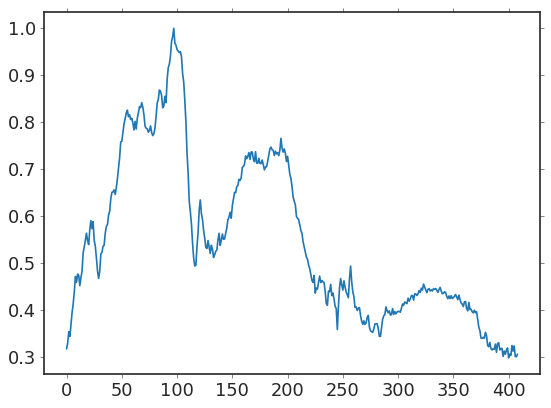

In [47]:
plt.plot(data['flux'][0])

In [48]:
X0= np.hstack((data['flux'], 1/40*data['sptype'][:,None])) #normalize the spectral type to be 1 at 40 we can also not add system type
y0= np.asarray(data['ortypes'])

#get rid of nans
nan_idxs= [idx for idx in range(len(X0)) if np.isnan(X0[idx]).any()]

X1=np.array([ X0[idx] for idx in range(len(X0)) if idx not in nan_idxs  ])
y1=np.array([ y0[idx] for idx in range(len(X0)) if idx not in nan_idxs  ])
len(nan_idxs), (X0.shape)

(10507, (100000, 410))

In [49]:
X0.shape

(100000, 410)

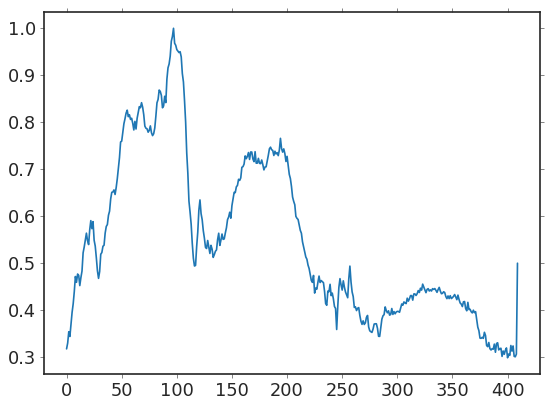

In [50]:
plt.plot(X0[0])

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X1,y1,train_size=0.85, shuffle=True)


In [52]:
X_train.shape
number_of_features=X_train.shape[-1]

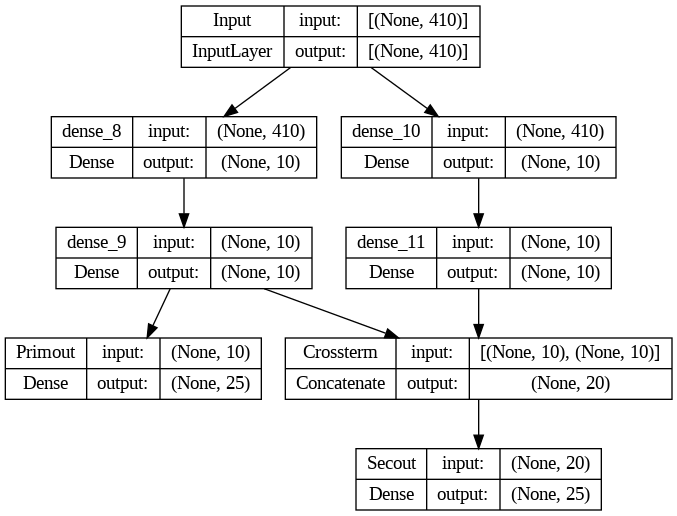

In [53]:
from numpy.lib.arraysetops import setxor1d
#model architecture: each later reduce the number of features to 100? --> as a starting point
I= Input(shape=(number_of_features,),name='Input')
P1 = Dense(10, activation='relu',  kernel_initializer='GlorotUniform')(I)
P2=Dense(10, activation='relu',  kernel_initializer='GlorotUniform')(P1)
P3= Dense(25,activation='softmax', name='Primout', kernel_initializer='GlorotUniform')(P2)

S1 = Dense(10, activation='relu', kernel_initializer='GlorotUniform')(I)
S2=Dense(10, activation='relu', kernel_initializer='GlorotUniform')(S1)
concatted = tf.keras.layers.Concatenate(name='Crossterm')([S2, P2])
S3= Dense(25,activation='softmax', name='Secout', kernel_initializer='GlorotUniform')(S2)
S4= Dense(25,activation='softmax', name='Secout', kernel_initializer='GlorotUniform')(concatted)

model = Model(inputs=[I],outputs=[P3,S4])
plot_model(model, show_shapes=True)

In [54]:
optimizer = keras.optimizers.Adam(learning_rate = 1e-4)
model.compile(optimizer=optimizer, loss=['mean_squared_error', 'mean_squared_error'])

In [55]:
#need this to make sense for the computer
def reshape_spectral_types(y):
  vals=[]
  #add 0 or if the spectral type is between 10 and 40
  for v in y:
    arr=np.zeros(40).astype(int)
    arr[int(v)]=1
    vals.append(arr[15:])
  return np.vstack(vals)
    

In [56]:
 reshape_spectral_types(y_train[:,0]).shape

(76069, 25)

In [57]:
model_history= model.fit(x=X_train, y={'Primout':  reshape_spectral_types(y_train[:,0]), \
                                       'Secout': reshape_spectral_types(y_train[:,1])}, epochs=20,\
                         validation_split=0.2, shuffle=True, verbose=True, batch_size=500)

Epoch 1/30
122/122 [==============================] - 3s 9ms/step - loss: 0.0757 - Primout_loss: 0.0380 - Secout_loss: 0.0377 - val_loss: 0.0750 - val_Primout_loss: 0.0377 - val_Secout_loss: 0.0373
Epoch 2/30
122/122 [==============================] - 1s 7ms/step - loss: 0.0733 - Primout_loss: 0.0365 - Secout_loss: 0.0368 - val_loss: 0.0718 - val_Primout_loss: 0.0354 - val_Secout_loss: 0.0364
Epoch 3/30
122/122 [==============================] - 1s 7ms/step - loss: 0.0708 - Primout_loss: 0.0346 - Secout_loss: 0.0362 - val_loss: 0.0695 - val_Primout_loss: 0.0336 - val_Secout_loss: 0.0360
Epoch 4/30
122/122 [==============================] - 1s 8ms/step - loss: 0.0678 - Primout_loss: 0.0321 - Secout_loss: 0.0357 - val_loss: 0.0654 - val_Primout_loss: 0.0300 - val_Secout_loss: 0.0354
Epoch 5/30
122/122 [==============================] - 1s 10ms/step - loss: 0.0639 - Primout_loss: 0.0286 - Secout_loss: 0.0353 - val_loss: 0.0627 - val_Primout_loss: 0.0274 - val_Secout_loss: 0.0353
Epoch 6/3

In [58]:
preds=model.predict(X_test)

420/420 [==============================] - 1s 2ms/step


[None, Text(0, 0.5, 'Loss'), Text(0.5, 0, 'Training Epochs')]

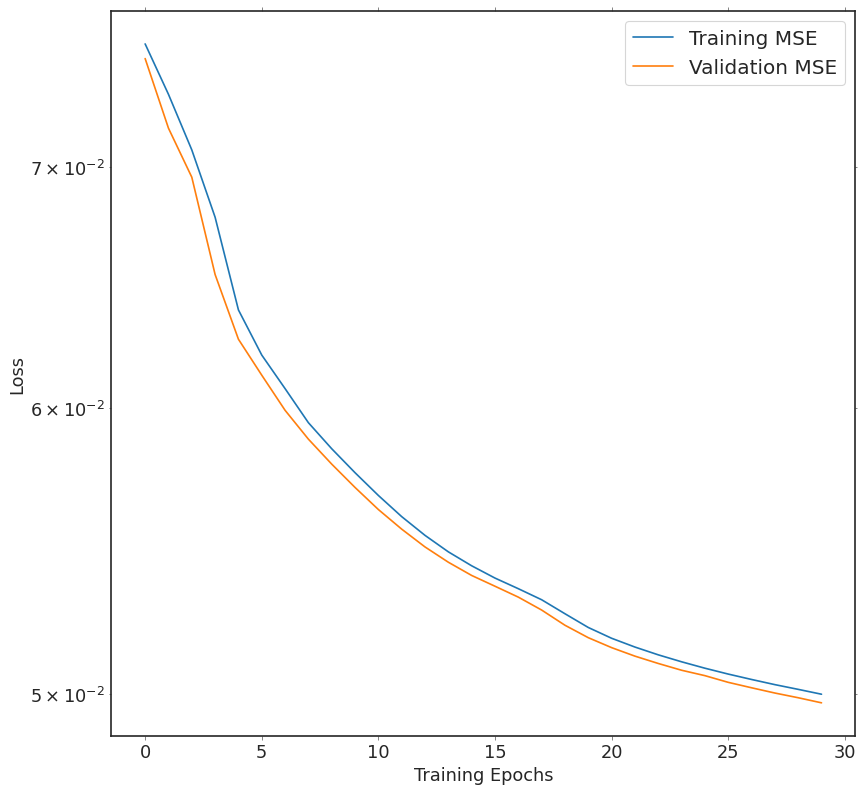

In [59]:
fig, ax=plt.subplots(figsize=(12, 12))

ax.plot(model_history.history['loss'], label='Training MSE')
ax.plot(model_history.history['val_loss'], label='Validation MSE')
plt.legend(fontsize=18)

#ax.plot(model_history.history['val_Primout_loss'],  linestyle='--', label='Primary Validation MSE')
#ax.plot(model_history.history['val_Secout_loss'],  linestyle='--',  label='Secondary Validation MSE')

ax.set(yscale='log', ylabel='Loss', xlabel='Training Epochs')

[Text(0.5, 1.0, 'True Secondaries Probabilities')]

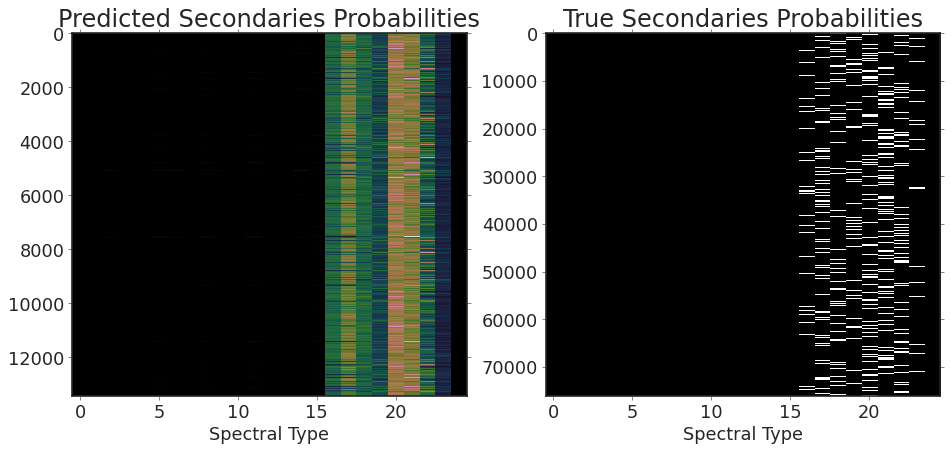

In [82]:
fig, ax=plt.subplots(ncols=2, figsize=(14, 6))
ax[0].imshow(preds[1],  interpolation='nearest', aspect='auto', cmap='cubehelix')
ax[1].imshow(reshape_spectral_types(y_train[:,1]),  interpolation='nearest', aspect='auto',  cmap='cubehelix')
for a in ax:
  a.set( xlabel='Spectral Type')

ax[0].set(title='Predicted Secondaries Probabilities')
ax[1].set(title='True Secondaries Probabilities')

[Text(0.5, 1.0, 'True Primaries Probabilities')]

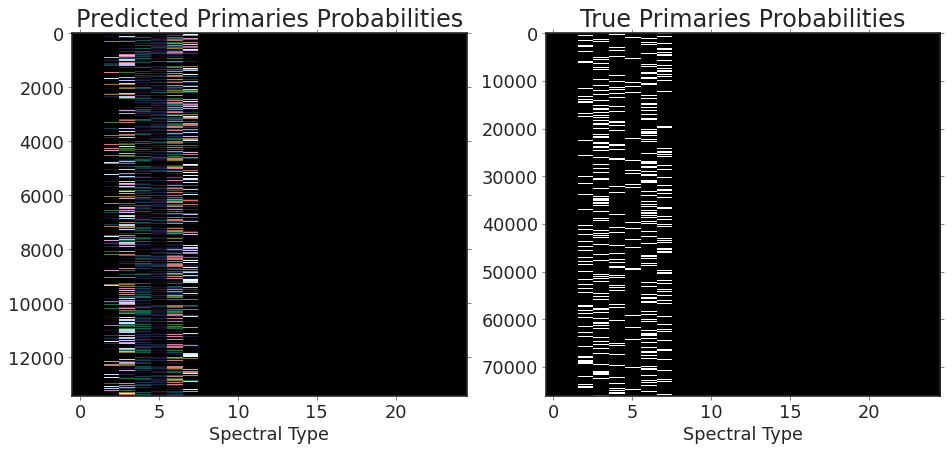

In [83]:
fig, ax=plt.subplots(ncols=2, figsize=(14, 6))
ax[0].imshow(preds[0],  interpolation='nearest', aspect='auto', cmap='cubehelix')
ax[1].imshow(reshape_spectral_types(y_train[:,0]),  interpolation='nearest', aspect='auto',  cmap='cubehelix')
for a in ax:
  a.set( xlabel='Spectral Type')

ax[0].set(title='Predicted Primaries Probabilities')
ax[1].set(title='True Primaries Probabilities')

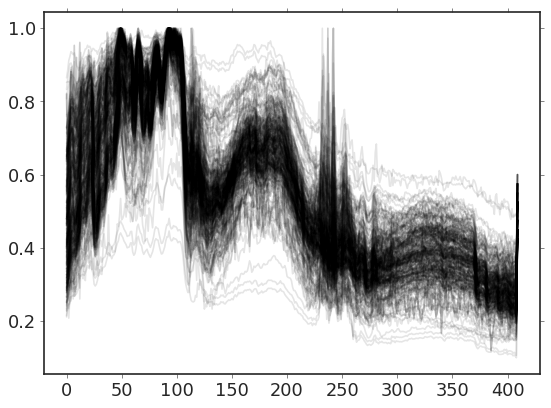

In [62]:
for idx in range(0, 300):
  _= plt.plot(X_train[idx], color='k', alpha=0.1)

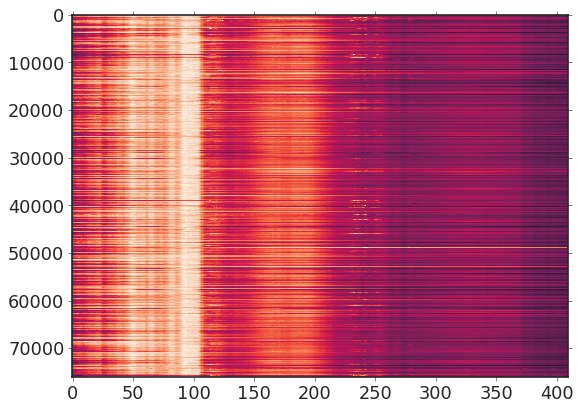

In [63]:
plt.imshow(X_train,  interpolation='nearest', aspect='auto')

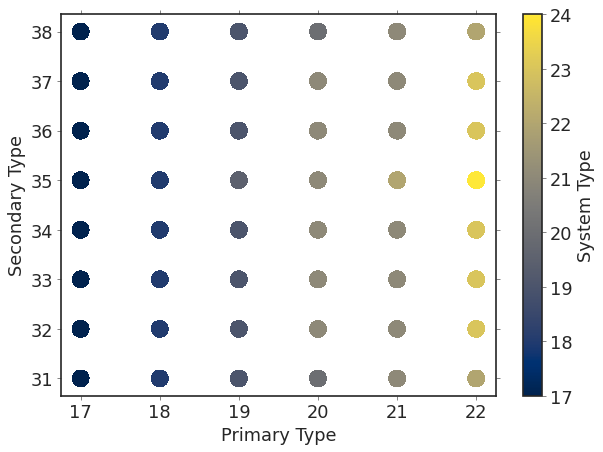

In [64]:
fig, ax=plt.subplots()
c=ax.scatter(data['ortypes'][:,0], data['ortypes'][:,1], c=data['sptype'], s=200, cmap='cividis')
plt.colorbar(c, label='System Type')
ax.set(xlabel='Primary Type', ylabel='Secondary Type')
plt.tight_layout()

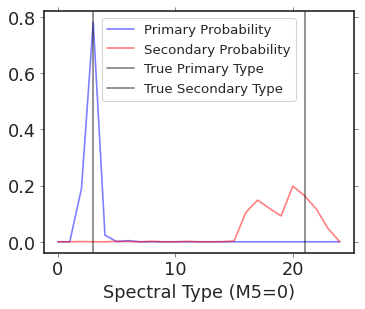

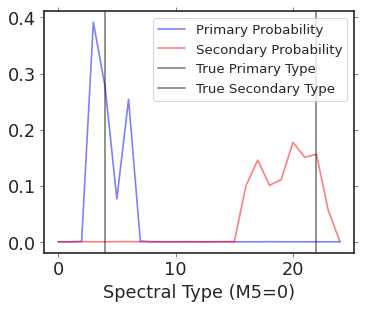

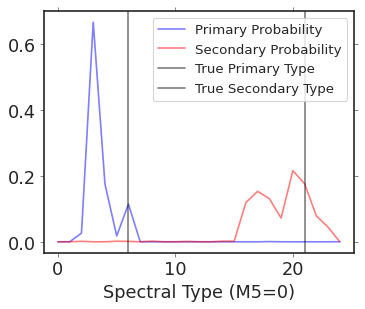

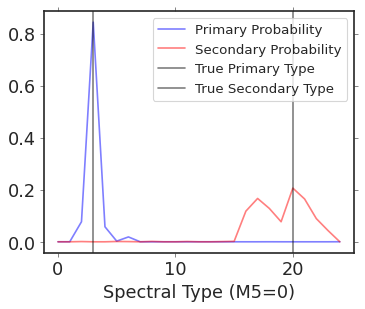

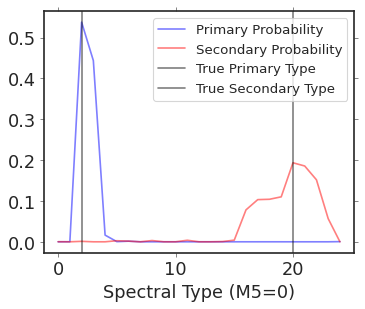

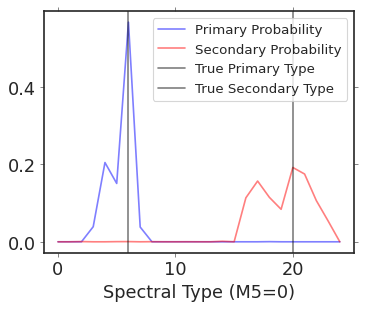

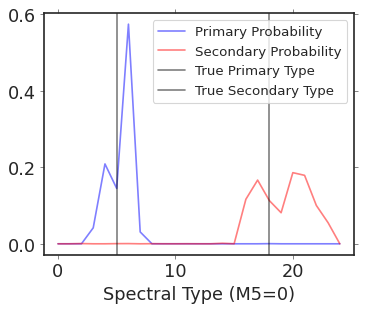

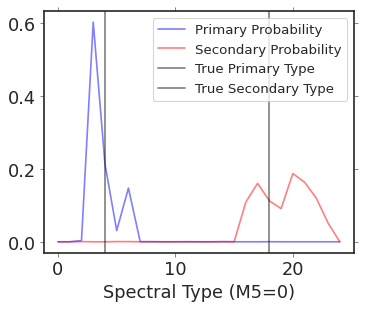

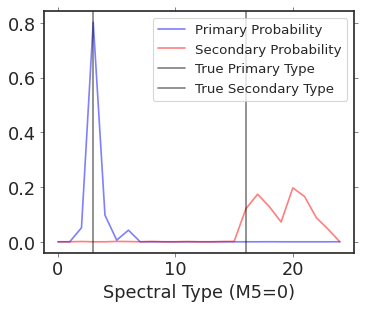

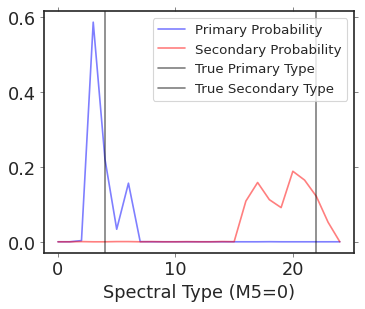

In [75]:
#try to plot probabilities for the first 10 objects

for idx in range(0, 10):
  fig, ax=plt.subplots(figsize=(5, 4))
  plt.plot(preds[0][idx], c='b', alpha=0.5, label='Primary Probability')
  plt.plot(preds[1][idx], c='r', alpha=0.5,  label='Secondary Probability')
  ax.axvline(y_test[idx][0]-15, c='black', alpha=0.5, label='True Primary Type')
  ax.axvline(y_test[idx][1]-15, c='black', alpha=0.5, label='True Secondary Type')
  ax.legend(fontsize=12)
  ax.set(xlabel='Spectral Type (M5=0)')

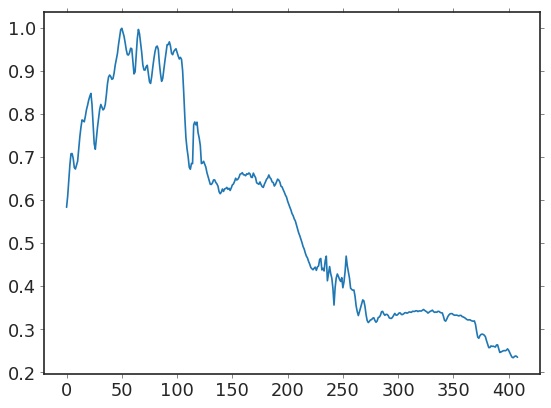

In [76]:
plt.plot(X_test[0][:-1])